In [10]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np


In [11]:
# Load and preprocess data
# Read the CSV file
data = pd.read_csv('data/TVC_logger_1_sedge.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%d/%m/%Y %H:%M')
data.set_index('DateTime', inplace=True)

In [12]:
# Split the data into training and testing sets (70% train, 30% test)
train_size = int(len(data) * 0.7)
train, test = data.iloc[:train_size], data.iloc[train_size:]

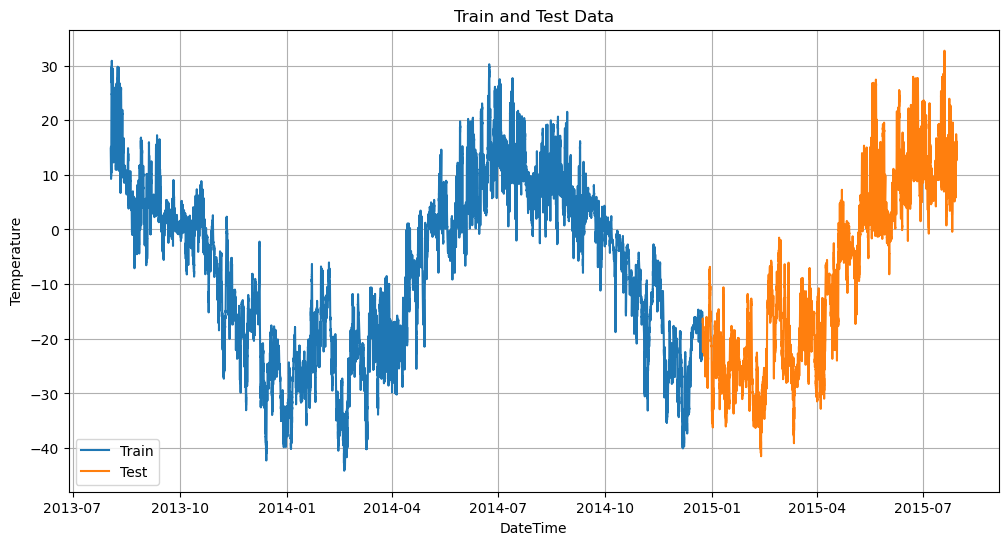

In [13]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(train['temp'], label='Train')
plt.plot(test['temp'], label='Test')
plt.title('Train and Test Data')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.grid(True)
plt.legend()
plt.show()

## ARIMA

In [18]:
# ARIMA Model
# Fit ARIMA model
model_arima = ARIMA(train['temp'], order=(1, 0, 1))
model_arima_fit = model_arima.fit()

# Forecast on the test set
forecast_arima_test = model_arima_fit.forecast(steps=len(test))
forecast_arima_test_df = pd.DataFrame(forecast_arima_test, index=test.index, columns=['Forecasted_Temp_ARIMA'])


/Users/roshanwithanage/opt/anaconda3/envs/KTP/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/Users/roshanwithanage/opt/anaconda3/envs/KTP/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
/Users/roshanwithanage/opt/anaconda3/envs/KTP/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


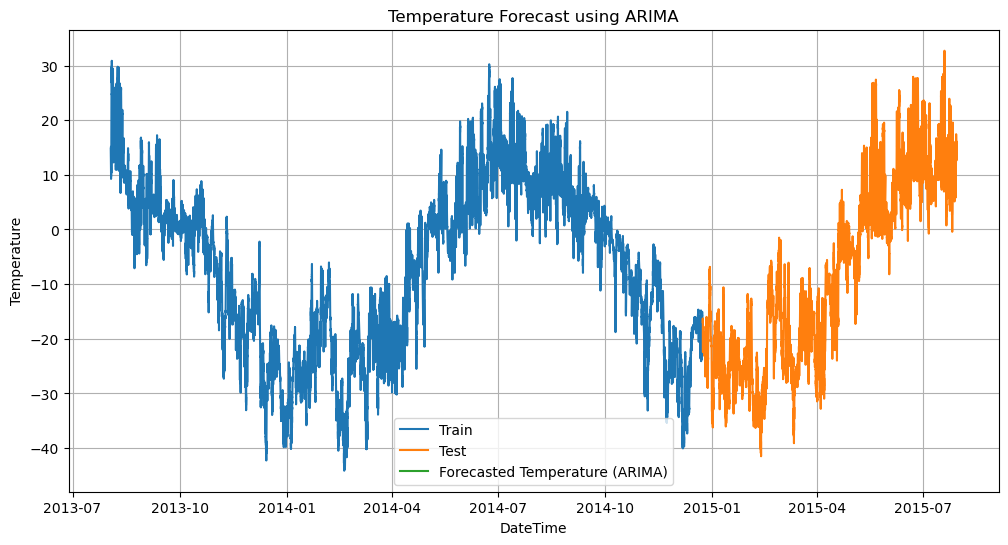

In [19]:
# Plot the forecasted values along with the real test data
plt.figure(figsize=(12, 6))
plt.plot(train['temp'], label='Train')
plt.plot(test['temp'], label='Test')
plt.plot(forecast_arima_test_df, label='Forecasted Temperature (ARIMA)')
plt.title('Temperature Forecast using ARIMA')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

## FBP

In [20]:
# Facebook Prophet Model
# Prepare data for Prophet
df_prophet_train = train.reset_index().rename(columns={'DateTime': 'ds', 'temp': 'y'})



In [21]:
# Fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet_train)

# Forecast on the test set
future_prophet = test.reset_index().rename(columns={'DateTime': 'ds'})
forecast_prophet = model_prophet.predict(future_prophet)

10:28:24 - cmdstanpy - INFO - Chain [1] start processing
10:29:10 - cmdstanpy - INFO - Chain [1] done processing


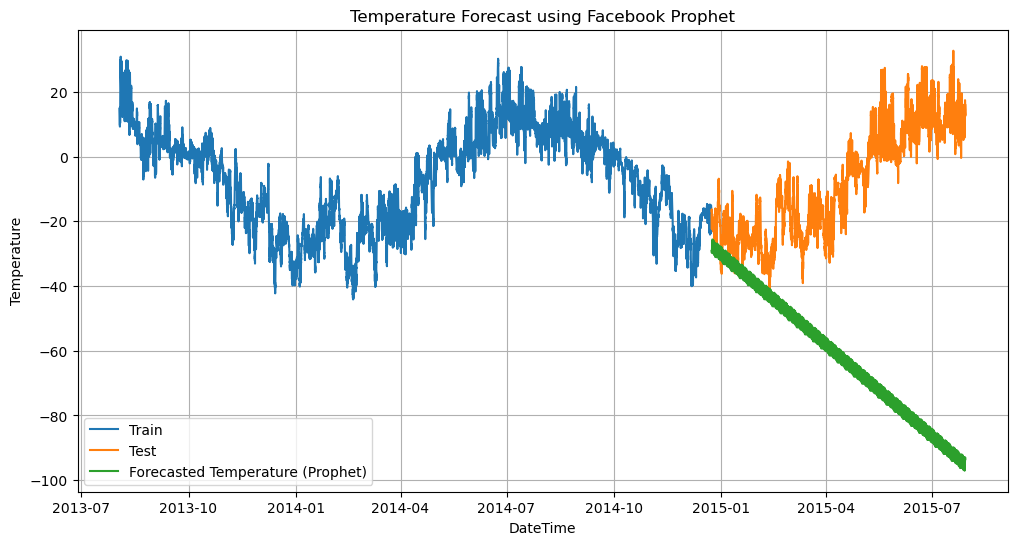

In [22]:
# Plot the forecasted values along with the real test data
plt.figure(figsize=(12, 6))
plt.plot(train['temp'], label='Train')
plt.plot(test['temp'], label='Test')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Forecasted Temperature (Prophet)')
plt.title('Temperature Forecast using Facebook Prophet')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

## LSTM

In [23]:
# LSTM Model
# Data preparation for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['temp'].values.reshape(-1, 1))

In [24]:
# Split the scaled data into train and test sets
scaled_train, scaled_test = scaled_data[:train_size], scaled_data[train_size:]

# Create a dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [25]:

time_step = 10
X_train, Y_train = create_dataset(scaled_train, time_step)
X_test, Y_test = create_dataset(scaled_test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
# Train the LSTM model
model_lstm.fit(X_train, Y_train, batch_size=1, epochs=1)

# Forecast on the test set
forecast_lstm = model_lstm.predict(X_test)
forecast_lstm = scaler.inverse_transform(forecast_lstm)

forecast_lstm_df = pd.DataFrame(forecast_lstm, index=test.index[time_step:], columns=['Forecasted_Temp_LSTM'])


980/980 [==============================] - 6s 5ms/step


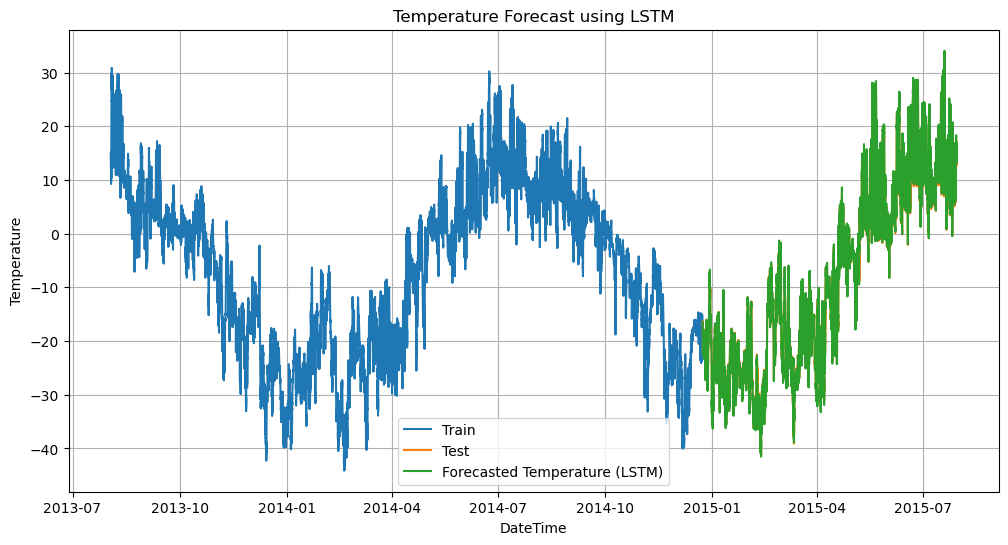

In [28]:
# Plot the forecasted values along with the real test data
plt.figure(figsize=(12, 6))
plt.plot(train['temp'], label='Train')
plt.plot(test['temp'], label='Test')
plt.plot(forecast_lstm_df, label='Forecasted Temperature (LSTM)')
plt.title('Temperature Forecast using LSTM')
plt.xlabel('DateTime')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Save the LSTM model
model_lstm.save('models/time_series/lstm_temperature_model.h5')

/Users/roshanwithanage/opt/anaconda3/envs/KTP/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
from keras.models import load_model

# Load the saved LSTM model
loaded_model_lstm = load_model('models/time_series/lstm_temperature_model.h5')